# Analysis production and production loss - Stockholm facility

In [1]:
# import some libraries to work with
import sys
sys.path.append('../packages')
from best_distribution import best_distribution as bd
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm 
import statistics
import seaborn as sns
import scipy.stats
import numpy as np

##### retrieve the max sustainable rate ophalen from the data

In [2]:
# get the max sustainable rate for Stockholm
msr_df = pd.read_json('../data/master_data.json', typ='series')

In [3]:
# store the max sustainable rate for Stockholm in a variable for later use
msr_stockholm = msr_df['STO msr']

##### retrieve the data for Stockholm

In [4]:
# get the stockholm data 
stockholm = list()
for bestandsnaam in os.listdir('../data/daily_production/STO/'):
    data = pd.read_json('../data/daily_production/STO/'+bestandsnaam, typ='series')
    row = pd.Series(data)
    stockholm.append(row)
    stockholm_data= pd.DataFrame(stockholm)

In [ ]:
# short check if this is the data that we can work with
stockholm_data

In [6]:
# derrive a new variable from the panda dataframe
stockholm_data_nulls = stockholm_data

##### check for null values and where they orginate from

- observation 1: in Stockholm, as in Brussels there is no #MV when there is no maintenance.
    - Meaning that when there is no maintenance, there is always production or production loss data.
- observation 2: we have no data if the maintenance is scheduled or not, we only notice that there is no data on days marked with maintenance 'yes'
    - we can determine for certain that in Stockholm there is no other recording than at hour 1 of the day there is no registration of maintenance on other timestamps

In [ ]:
# let's check the fields that are marked with maintenance 'yes'
for index, field in stockholm_data_nulls.iterrows() :
    if field['maintenance']=="Yes":
        display(field)

In [8]:
# check if there is #MV values when maintenance is not 'yes'
for index, field in stockholm_data_nulls.iterrows() :
    if  field['production']=='#MV' and field['maintenance']!="Yes":
        display(field)

In [9]:
# check if maintenance is set on other timestamps than 1
for index, field in stockholm_data_nulls.iterrows() :
    if field['maintenance']=="Yes" and field['hour'] !=1:
        display(field)

##### first couple of conclusions:

- to make a prediction of the production capability of brussels  we can remove the rows where the record is marked with maintenance yes, since the task is to make a simulation, not to check for optimalisations in maintenance
- we can make the #MV values as 0 and plot them to see when the specific timings of maintenance occur (if there is time left)

In [10]:
# creating a new df with the dropped the #MV records 
stockholm_data_wo_nulls = stockholm_data.replace({"#MV": np.nan}).dropna()

In [ ]:
# check the dataframe
display(stockholm_data_wo_nulls)

In [12]:
# let's set the objects to ints so we can use them for the graphs
stockholm_data_wo_nulls['production'] = stockholm_data_wo_nulls['production'].astype(int)
stockholm_data_wo_nulls['prod_loss']  = stockholm_data_wo_nulls['prod_loss'].astype(int)
# percentage is not used but we int it anyway just to do a describe of the dataframe
stockholm_data_wo_nulls['prod_loss_perc']  = stockholm_data_wo_nulls['prod_loss_perc'].astype(int)

In [13]:
# let's describe the dataset
stockholm_data_wo_nulls.describe()

,hour,minute,prod_loss,prod_loss_perc,production
count,1716.0,1716.0,1716.000000,1716.000000,1716.000000
mean,1.0,0.0,97.054196,35.429487,176.945804
std,0.0,0.0,63.080946,23.018391,63.080946
min,1.0,0.0,9.000000,3.000000,0.000000
25%,1.0,0.0,62.750000,23.000000,182.000000
50%,1.0,0.0,73.000000,27.000000,201.000000
75%,1.0,0.0,92.000000,33.250000,211.250000
max,1.0,0.0,274.000000,100.000000,265.000000


In [14]:
# let's separate the production and production loss into pandas series 
stockholm_production_wo_nulls  =stockholm_data_wo_nulls['production']
stockholm_prod_loss_wo_nulls  =stockholm_data_wo_nulls['prod_loss']

##### visualize the data  for production and production loss 

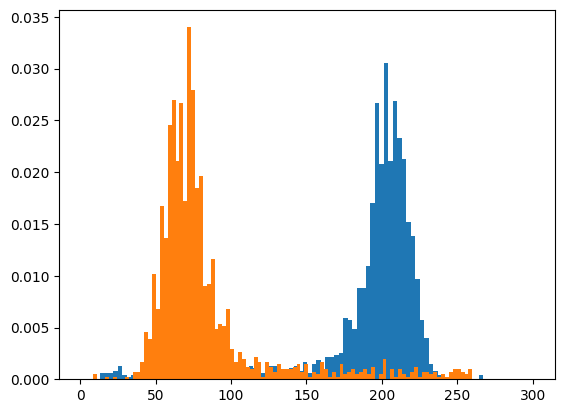

In [15]:
# make a hist plot of the production and the production loss
# let's the zeros from the histview on the distribution 
# we can see a nice pattern emerging around the 1000 for production and around 250 for production loss
plt.hist(stockholm_production_wo_nulls,range=(1,300),bins=100, density = True);
plt.hist(stockholm_prod_loss_wo_nulls,range=(1,260),bins=100, density = True);

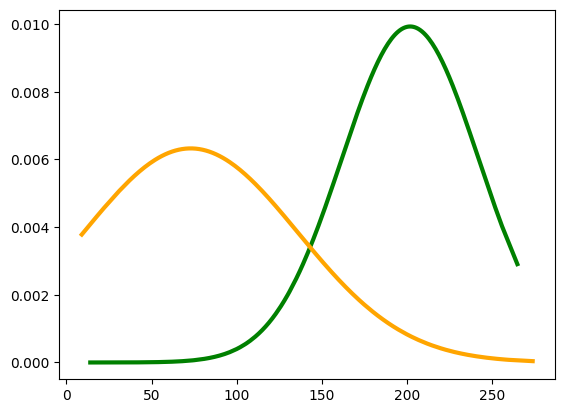

In [16]:
# let's make a nicer plot to see how the distribution look like

x_axis = (stockholm_production_wo_nulls.replace({0: np.nan}).dropna(axis=0)).sort_values()
x_axis_2 = (stockholm_prod_loss_wo_nulls.replace({0: np.nan}).dropna(axis=0)).sort_values()
# Calculating mean and standard deviation 
mean = statistics.mean(x_axis) 
sd = statistics.stdev(x_axis) 
mdian = statistics.median(x_axis)
mean_2 = statistics.mean(x_axis_2) 
sd_2 = statistics.stdev(x_axis_2) 
mdian_2 = statistics.median(x_axis_2)
plt.plot(x_axis, norm.pdf(x_axis, mdian, sd),color='green', linewidth=3) 
plt.plot(x_axis_2, norm.pdf(x_axis_2, mdian_2, sd_2),color='orange', linewidth=3) 
plt.show()

### detailed production analysis

In [17]:
# store some values in variables for use in the next few cells
display_production_data_stockholm = stockholm_production_wo_nulls.sort_values()

production_mean = display_production_data_stockholm.mean()
production_median = np.median(display_production_data_stockholm)
production_std = statistics.pstdev(display_production_data_stockholm)
production_variance = np.var(display_production_data_stockholm)
skew = ("negative skew" 
        if np.median(display_production_data_stockholm)-display_production_data_stockholm.mean()>0 
        else "positive skew")

176.9458041958042 is the mean
201.0 is the median
Variance: 3976.8869229546835
63.06256356155106 is the standard deviation
negative skew


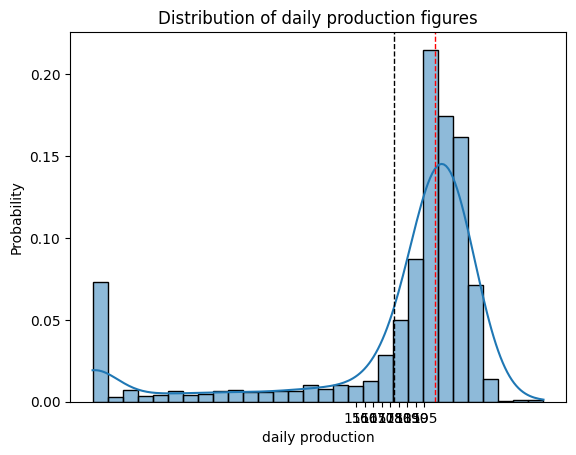

In [18]:
# based on everything above we make a better plot for production data that shows also the details
# mean, variance, standard deviation, skew and median,
# along with a very cool graph that represents all of this


sns.histplot(display_production_data_stockholm, bins=30, kde=True, stat='probability')
plt.axvline(production_mean, color='black', linestyle='dashed', linewidth=1)
plt. axvline(production_median, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('daily production')
plt.ylabel('Probability')
plt.title("Distribution of daily production figures")
plt.xticks(range(155,200,5))
print(f'{production_mean} is the mean')
print(f'{production_median} is the median')
print(f"Variance: {production_variance}")
print(f'{production_std} is the standard deviation')
print(f'{skew}')
plt.show()



In [19]:
# let's use the shared function to doublecheck the results
best_distribution, best_params = bd.find_best_fit_distribution_continuous(stockholm_production_wo_nulls)
 

# Print the best-fit distribution and its parameters
print(f"Best-fit distribution: {best_distribution.name}")
print(f"Parameters: {best_params}")

Best-fit distribution: norm
Parameters: (176.9458041958042, 63.062563561551066)


##### simulation for the production

In [ ]:
# set the number of days and capture the returned list from the function
aantal_dagen=10
voorspellingen_production = bd.simulatie(production_mean, production_std, msr_stockholm,aantal_dagen)
totaal =0
print(f'de volgende {aantal_dagen} dagen is dit de mogelijke productie: ')
for voorspelling in voorspellingen_production:
    print (f' {voorspelling}')
    totaal +=voorspelling
print(f'de mogelijke hoeveelheid productie voor de volgende {aantal_dagen} dagen is: {totaal}')

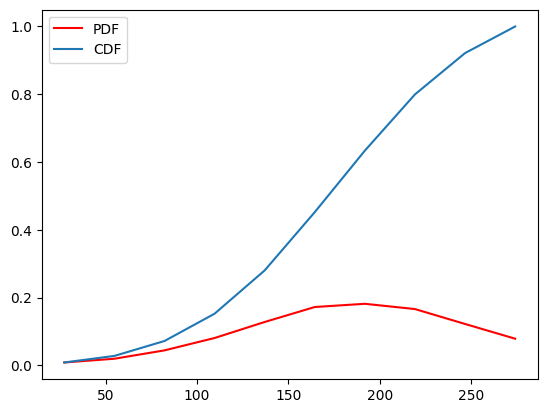

In [21]:
# we use the production_mean and production_std we calculated before
# msr_stockholm was already determined almost at the beginning of this notebook
# pdf = probability distribution function, cdf= cumulative distribution function
cdf__production_data = bd.simulatie(production_mean, production_std, msr_stockholm,10**5)
count, bins_count = np.histogram(cdf__production_data, bins=10) 
  
# finding the PDF of the histogram using count values 
pdf_production = count / sum(count) 
  
# using numpy np.cumsum to calculate the CDF 
# We can also find using the PDF values by looping and adding 
cdf_production = np.cumsum(pdf_production) 
  
# plotting PDF and CDF 
plt.plot(bins_count[1:], pdf_production, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf_production, label="CDF") 
plt.legend() 

Text(0, 0.5, '$p$')

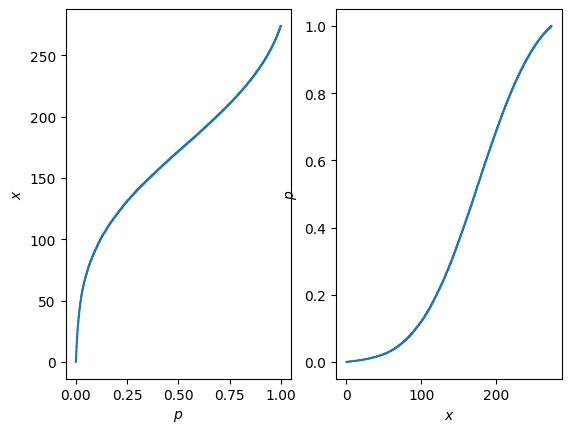

In [22]:
# example found on stack overflow, cumulative distribution function

cdf_data = bd.simulatie(production_mean, production_std, msr_stockholm,10**5)
cdf_data_sorted = np.sort(cdf_data)

p = 1. * np.arange(len(cdf_data)) / (len(cdf_data) - 1)

# plot the sorted data:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(p, cdf_data_sorted)
ax1.set_xlabel('$p$')
ax1.set_ylabel('$x$')

ax2 = fig.add_subplot(122)
ax2.plot(cdf_data_sorted, p)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$p$')

### detailed production loss analysis

In [ ]:
# let's calculate some values and store them for use in the next few cells
data_to_display_prod_loss = stockholm_prod_loss_wo_nulls.sort_values()

# with the above figures I can recreate a normal distribution with numpy:
prod_loss_mean = data_to_display_prod_loss.mean()
prod_loss_median = np.median(data_to_display_prod_loss)
prod_loss_std = statistics.pstdev(data_to_display_prod_loss)
prod_loss_var = np.var(data_to_display_prod_loss)
skew = ("negative skew"
        if np.median(data_to_display_prod_loss)-data_to_display_prod_loss.mean()>0
        else "positive skew")

97.0541958041958 is the mean
73.0 is the median
Variance: 3976.8869229546553
63.06256356155106 is the standard deviation
positive skew


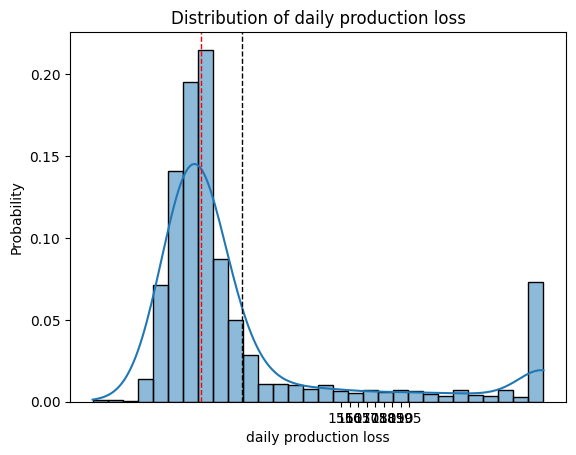

In [23]:
# based on everything above we make a better plot for production loss data that shows also the details
# mean, variance, standard deviation, skew and median,
# along with a very cool graph that represents all of this

sns.histplot(data_to_display_prod_loss, bins=30, kde=True, stat='probability')
plt.axvline(prod_loss_mean, color='black', linestyle='dashed', linewidth=1)
plt. axvline(prod_loss_median, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('daily production loss')
plt.ylabel('Probability')
plt.title("Distribution of daily production loss")
plt.xticks(range(155,200,5))
print(f'{prod_loss_mean} is the mean')
print(f'{prod_loss_median} is the median')
print(f"Variance: {prod_loss_var}")
print(f'{prod_loss_std} is the standard deviation')
print(f'{skew}')
plt.show()

##### simulation for the production loss

In [ ]:
aantal_dagen= 7
voorspellingen_production_verlies = bd.simulatie(prod_loss_mean, prod_loss_std, msr_stockholm, aantal_dagen)
totaal =0
print(f'de volgende {aantal_dagen} dagen is dit het mogelijke productie verlies: ')
for voorspelling in voorspellingen_production_verlies:
    print (f' {voorspelling}')
    totaal +=voorspelling
print(f'de mogelijke hoeveelheid productie verlies voor de volgende {aantal_dagen} dagen is: {totaal}')

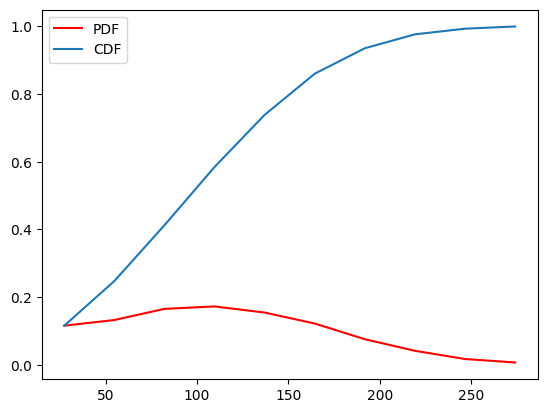

In [25]:
# in this section we reuse the prod_loss_mean and prod_loss_std that we calculated in field 23
# pdf = probability distribution function, cdf= cumulative distribution function
cdf_prod_loss_data = bd.simulatie(prod_loss_mean, prod_loss_std, msr_stockholm,10**5)
count, bins_count = np.histogram(cdf_prod_loss_data, bins=10) 
  
# finding the PDF of the histogram using count values 
pdf_prod_loss = count / sum(count) 
  
# using numpy np.cumsum to calculate the CDF 
cdf_prod_loss = np.cumsum(pdf_prod_loss) 
  
# plotting PDF and CDF 
plt.plot(bins_count[1:], pdf_prod_loss, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf_prod_loss, label="CDF") 
plt.legend() 

### details production loss percent

- could be used to make some better prediction on production loss, but not used for now

In [26]:
stockholm_prod_loss_perc_wo_nulls  =stockholm_data_wo_nulls['prod_loss_perc']

In [27]:
stockholm_prod_loss_perc_wo_nulls.describe()

count    1716.000000
mean       35.429487
std        23.018391
min         3.000000
25%        23.000000
50%        27.000000
75%        33.250000
max       100.000000
Name: prod_loss_perc, dtype: float64

In [29]:
# let's calculate some values and store them for use in the next few cells
data_to_display_prod_loss_perc = stockholm_prod_loss_perc_wo_nulls.sort_values()

# with the above figures I can recreate a normal distribution with numpy:
prod_loss_perc_mean = data_to_display_prod_loss_perc.mean()
prod_loss_perc_median = np.median(data_to_display_prod_loss_perc)
prod_loss_perc_std = statistics.pstdev(data_to_display_prod_loss_perc)
prod_loss_perc_var = np.var(data_to_display_prod_loss_perc)
skew_prod_loss_perc = ("negative skew"
                       if np.median(data_to_display_prod_loss_perc)-data_to_display_prod_loss_perc.mean()>0
                       else "positive skew")

35.42948717948718 is the mean
27.0 is the median
Variance: 529.5375687346826
23.011683309455744 is the standard deviation
positive skew


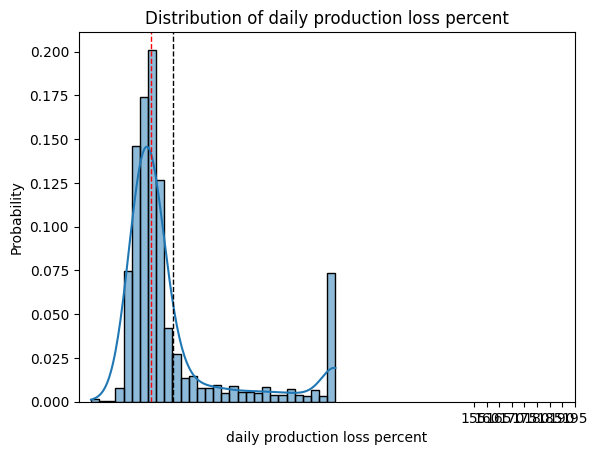

In [28]:
# based on everything above we make a better plot for production loss data that shows also the details
# mean, variance, standard deviation, skew and median,
# along with a very cool graph that represents all of this


#numpy_data_prod_loss = np.random.normal(data_mean_prod_loss, data_std_prod_loss)
#numpy_data_prod_loss = (numpy_data_prod_loss - data_mean_prod_loss)/data_std_prod_loss

sns.histplot(data_to_display_prod_loss_perc, bins=30, kde=True, stat='probability')
plt.axvline(prod_loss_perc_mean, color='black', linestyle='dashed', linewidth=1)
plt. axvline(prod_loss_perc_median, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('daily production loss percent')
plt.ylabel('Probability')
plt.title("Distribution of daily production loss percent")
plt.xticks(range(155,200,5))
print(f'{prod_loss_perc_mean} is the mean')
print(f'{prod_loss_perc_median} is the median')
print(f"Variance: {prod_loss_perc_var}")
print(f'{prod_loss_perc_std} is the standard deviation')
print(f'{skew_prod_loss_perc}')
plt.show()